In [1]:
import sys
sys.path.append("scripts")  # Add the path to the scripts folder
#import script_file_1

import h5py
import pickle
import os
import pandas as pd


In [2]:
# create list of file_paths to loop over and extract data from 
sess_dir = 'C:/code/SMTB_2023/imaging/data/5546'

save_dir = sess_dir + '/5546_total.pkl'

# LOAD DATA FROM MULTIPLE SESSIONS
C_arrays = []
cvs = []
boris1s = []

# List of files to analyze
files_to_analyze = ['C:/code/SMTB_2023/imaging/data/5546/day0_corr08_pnr5_total.pkl',
                    'C:/code/SMTB_2023/imaging/data/5546/day1_corr08_pnr6_total.pkl',
                    'C:/code/SMTB_2023/imaging/data/5546/day2_corr08_pnr5_total.pkl',
                    'C:/code/SMTB_2023/imaging/data/5546/day14_corr08_pnr8_total.pkl']

# Loop through files and store the data
for file_path in files_to_analyze:
    with open(file_path, 'rb') as file:
        C_array, cv, boris1 = pickle.load(file)
        C_arrays.append(C_array)
        cvs.append(cv)
        boris1s.append(boris1)
        
partnerString = ['left', 'left'] #partner was left on days 2 and 14

# on PPT days, there are partners and novels, so lets rename behaviors appropriately so that they're
# easily indexable 

# 5546 - partner on left day 2, 

day2temp = boris1s[2]
day2temp.loc[(day2temp['Behavior'] == 'noncontact investigation')& (day2temp['Subject'] == 'Right'), 'Behavior'] = 'noncontact investigation right'
day2temp.loc[(day2temp['Behavior'] == 'noncontact investigation')& (day2temp['Subject'] == 'Left'), 'Behavior'] = 'noncontact investigation left'
day2temp.loc[(day2temp['Behavior'] == 'contact investigation')& (day2temp['Subject'] == 'Right'), 'Behavior'] = 'contact investigation right'
day2temp.loc[(day2temp['Behavior'] == 'contact investigation')& (day2temp['Subject'] == 'Left'), 'Behavior'] = 'contact investigation left'
boris1s[2] = day2temp

day14temp = boris1s[3]
day14temp.loc[(day14temp['Behavior'] == 'noncontact investigation')& (day14temp['Subject'] == 'Right'), 'Behavior'] = 'noncontact investigation right'
day14temp.loc[(day14temp['Behavior'] == 'noncontact investigation')& (day14temp['Subject'] == 'Left'), 'Behavior'] = 'noncontact investigation left'
day14temp.loc[(day14temp['Behavior'] == 'contact investigation')& (day14temp['Subject'] == 'Right'), 'Behavior'] = 'contact investigation right'
day14temp.loc[(day14temp['Behavior'] == 'contact investigation')& (day14temp['Subject'] == 'Left'), 'Behavior'] = 'contact investigation left'
boris1s[3] = day14temp

In [3]:
# Lets print out various behavioral metrics

# day 0s and 1: calculate ?

# day 2: calculate PP and secs spent 
day2PPT = cvs[2]

behavior_right = day2PPT[day2PPT['EventType'] == 'Social Contact [ 1 with 3 ] in Area Right while Joint Motion < 0.030']
total_right = sum(behavior_right.LengthinSec)

behavior_left = day2PPT[day2PPT['EventType'] == 'Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030']
total_left = sum(behavior_left.LengthinSec)

pp = total_left / (total_left + total_right)
ppPercent = pp*100
print(f"secs spent with partner is {total_left}")
print(f"secs spent with novel is {total_right}")
print(f"partner preference on day 2 is {ppPercent}")




day14PPT = cvs[2]

behavior_right = day14PPT[day14PPT['EventType'] == 'Social Contact [ 1 with 3 ] in Area Right while Joint Motion < 0.030']
total_right = sum(behavior_right.LengthinSec)

behavior_left = day14PPT[day14PPT['EventType'] == 'Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030']
total_left = sum(behavior_left.LengthinSec)

pp = total_left / (total_left + total_right)
ppPercent = pp*100
print(f"secs spent with partner is {total_left}")
print(f"secs spent with novel is {total_right}")
print(f"partner preference on day 14 is {ppPercent}")


#behavior_data = day2PPT[day2PPT['EventType'] == 'Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030']



secs spent with partner is 759.0600000000001
secs spent with novel is 63.96000000000001
partner preference on day 2 is 92.22862141867755
secs spent with partner is 759.0600000000001
secs spent with novel is 63.96000000000001
partner preference on day 14 is 92.22862141867755


In [ ]:
type(boris1)

In [ ]:
cvs[2]

In [ ]:
cvs[2]['EventType'].unique()

In [5]:
## Correlation Matrix
# Highlighting anything above the threshold of correlation defined in the input
# Just a bit of data checking to make sure there aren't
# cells that are possibly the same and should be merged


import numpy as np
import matplotlib.pyplot as plt

def pearson_correlation_matrix(matrix, threshold):
    # Calculate the Pearson correlation coefficient matrix
    correlation_matrix = np.corrcoef(matrix, rowvar=False)
    return correlation_matrix

def plot_correlation_matrix(correlation_matrix):
    # Create a mask to highlight correlations above the threshold
    mask = np.abs(correlation_matrix) >= threshold
    
    # Set the elements above the diagonal to NaN
    correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)] = np.nan
    
    # Plot the correlation matrix below the diagonal
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            if mask[i, j]:
                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='yellow', linewidth=2, fill=False)
                plt.gca().add_patch(rect) 
    
    plt.colorbar()
    plt.title("Pearson's Correlation Matrix")
    plt.show()


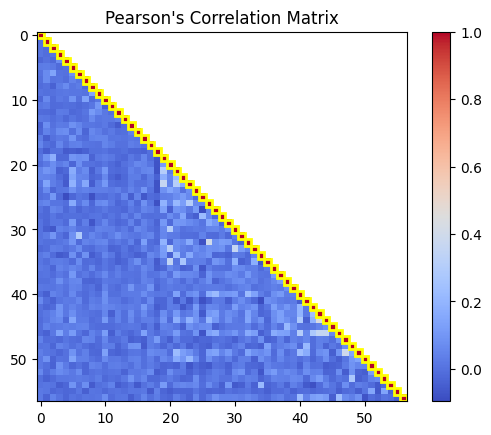

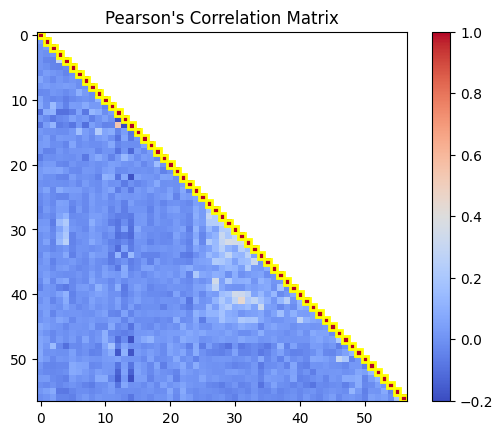

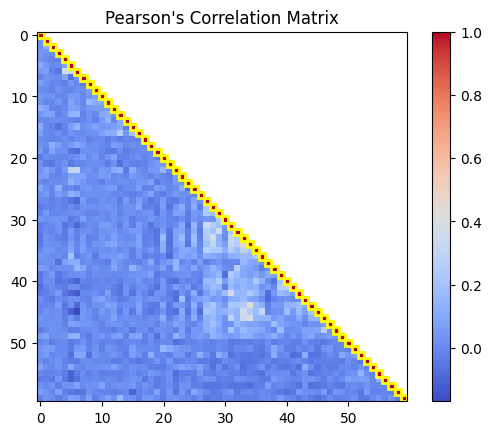

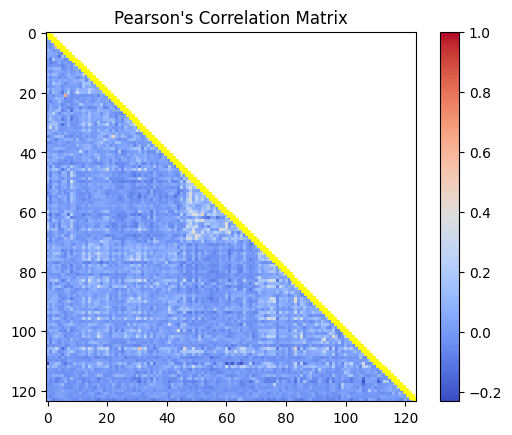

In [6]:
threshold = 0.8
import pdb
for C_array in zip(C_arrays):
    temp = np.transpose(np.squeeze(C_array))
    #pdb.set_trace()
    correlation_matrix = pearson_correlation_matrix(temp, threshold)
    plot_correlation_matrix(correlation_matrix)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def visualize_2D_matrix_with_shading(matrix, behavior_df, behavior_name, default_vmax=1.0):
    def update_plot(colormap, vmin, vmax):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.imshow(matrix, cmap=colormap, vmin=vmin, vmax=vmax, aspect='auto')
        plt.colorbar()
        plt.title("One-Photon Calcium Imaging 2D Matrix")
        plt.xlabel("Time")
        plt.ylabel("Neurons")
        
        # Get 'scopeFrameStart' and 'scopeFrameEnd' values for the specified behavior name
        behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
        start_frames = behavior_data['scopeFrameStart'].values
        end_frames = behavior_data['scopeFrameEnd'].values
        
        # Plot shaded regions for 'scopeFrameStart' and 'scopeFrameEnd'
        for start_frame, end_frame in zip(start_frames, end_frames):
            plt.axvspan(start_frame, end_frame, color='lightblue', alpha=0.6)
        
        plt.show()

    # Define interactive widgets (same as before)
    colormap_selector = widgets.Dropdown(
        options=['viridis', 'plasma', 'inferno', 'magma', 'cividis'],
        value='viridis',
        description='Colormap:',
    )

    vmin_slider = widgets.FloatSlider(
        value=np.min(matrix),
        min=np.min(matrix),
        max=np.max(matrix),
        step=0.1,
        description='Min Value:',
    )
    
    vmax_slider = widgets.FloatSlider(
        value=default_vmax,
        min=np.min(matrix),
        max=np.max(matrix),
        step=0.1,
        description='Max Value:',
    )

    # Create the interactive plot (same as before)
    interactive_plot = widgets.interactive(
        update_plot,
        colormap=colormap_selector,
        vmin=vmin_slider,
        vmax=vmax_slider,  # Using the checkbox value directly for vmax_auto
    )

    display(interactive_plot)


In [5]:
%matplotlib notebook


In [6]:
default_vmax = 10.0
for C_array, boris1 in zip(C_arrays, boris1s):
    visualize_2D_matrix_with_shading(C_array, boris1, 'noncontact investigation', default_vmax=10)
    
#visualize_2D_matrix_with_shading(C_arrays[0], boris1[0], 'mount', default_vmax=10)

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

In [7]:
def get_transient_timestamps(
    neural_data, thresh_type="eps", do_zscore=True, std_thresh=5
):
    """
    Converts an array of continuous time series (e.g., traces or S)
    into lists of timestamps where activity exceeds some threshold.

    :parameters
    ---
    neural_data: (neuron, time) array
        Neural time series, (e.g., C or S).

    std_thresh: float
        Number of standard deviations above the mean to define threshold.

    :returns
    ---
    event_times: list of length neuron
        Each entry in the list contains the timestamps of a neuron's
        activity.

    event_mags: list of length neuron
        Event magnitudes.

    """
    # Compute thresholds for each neuron.
    neural_data = np.asarray(neural_data, dtype=np.float32)
    if thresh_type == "eps":
        thresh = np.repeat(np.finfo(np.float32).eps, neural_data.shape[0])
    else:
        if do_zscore:
            stds = np.std(neural_data, axis=1)
            #print(stds.shape)
            means = np.mean(neural_data, axis=1)
            thresh = means + std_thresh * stds
        else:
            thresh = np.repeat(std_thresh, neural_data.shape[0])

    # Get event times and magnitudes.
    bool_arr = neural_data > np.tile(thresh, [neural_data.shape[1], 1]).T

    event_times = [np.where(neuron > t)[0] for neuron, t in zip(neural_data, thresh)]

    event_mags = [neuron[neuron > t] for neuron, t in zip(neural_data, thresh)]

    return event_times, event_mags, bool_arr

In [8]:
## ANALYSIS IDEA - lets include multiple 'algorithms' here to define our binary in different ways
#1- not only does the value have to be above the thresh, but it also has to be greater than the 
#value before and after it 

In [9]:
## Convert to boolean
# List to store data from multiple files
events = []
magnitudes = []
bool_arr = []

# Loop through files and store the data
for C_array in C_arrays:
    event_single, magnitude_single, bool_single = get_transient_timestamps(C_array, thresh_type='zscore', std_thresh=5)
    events.append(event_single)
    magnitudes.append(magnitude_single)
    bool_arr.append(bool_single)
 

In [ ]:
print(std.shape)

In [ ]:
bool_arr

In [10]:
#visualize_2D_matrix_with_shading(bool_arr, boris1, '', default_vmax=1)

for bool_single in bool_arr:
    visualize_2D_matrix_with_shading(bool_single, boris1, 'noncontact investigation', default_vmax=10)

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

interactive(children=(Dropdown(description='Colormap:', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

In [24]:
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.stats import sem

def plot_time_locked_responses(matrix, behavior_df, behavior_name, window_before_sec=1, window_after_sec=1, frame_rate=15, ax=0):
    # Convert time windows from seconds to frames
    window_before_frames = int(window_before_sec * frame_rate)
    window_after_frames = int(window_after_sec * frame_rate)

    # Get the behavior data for the specified behavior name
    behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
    behavior_start_frame = behavior_data['scopeFrameStart'].values
    behavior_end_frame = behavior_data['scopeFrameEnd'].values

    # Calculate the view start and view end based on the specified window_before_frames and window_after_frames
    view_start = behavior_start_frame - window_before_frames
    view_end = behavior_start_frame + window_after_frames

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    # Calculate the time points relative to the behavior event in seconds
    time_points = np.linspace(0, (15*(window_before_sec + window_after_sec)), 61)

    time_locked_responses = []
    
    view_start_filtered = []
    view_end_filtered = []
    
    for view_start_ev, view_end_ev in zip(view_start, view_end):
        if view_start_ev > 0:
            view_start_filtered.append(view_start_ev)
            view_end_filtered.append(view_end_ev)
    
    # For each event, extract the time-locked responses for all cells
    for ev_start, ev_end in zip(view_start_filtered, view_end_filtered):
        event_slice = matrix[:, ev_start:ev_end+1]
        median_response = np.median(event_slice, axis=0)
        time_locked_responses.append(median_response)
       #time_locked_responses = matrix[:, ev_start:ev_end + 1]

    #pdb.set_trace()
    time_locked_responses_matrix = np.array(time_locked_responses)
    # Calculate mean and standard deviation across all cells for each time point
    response_across_events = np.median(time_locked_responses, axis=0)
    std_response = sem(time_locked_responses, axis=0)

    
   
    #fig, ax = plt.subplots(figsize=(12,6))
        
    # Plot mean and standard deviation
    #pdb.set_trace()
    ax.plot(time_points, response_across_events, color='b', lw=2, label='Mean')
    ax.fill_between(time_points, response_across_events - std_response, response_across_events + std_response,
                     color='b', alpha=0.3, label='Standard Deviation')

    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Vertical line at behavior event

    ax.set_title(f"Time-Locked Responses to Behavior: {behavior_name}")
    ax.set_xlabel("Time Relative to Behavior Event (seconds)")
    ax.set_ylabel("Calcium DF/F")
    ax.grid(True)
    ax.legend()
    #pdb.set_trace()
    #plt.show()
    
    

<IPython.core.display.Javascript object>


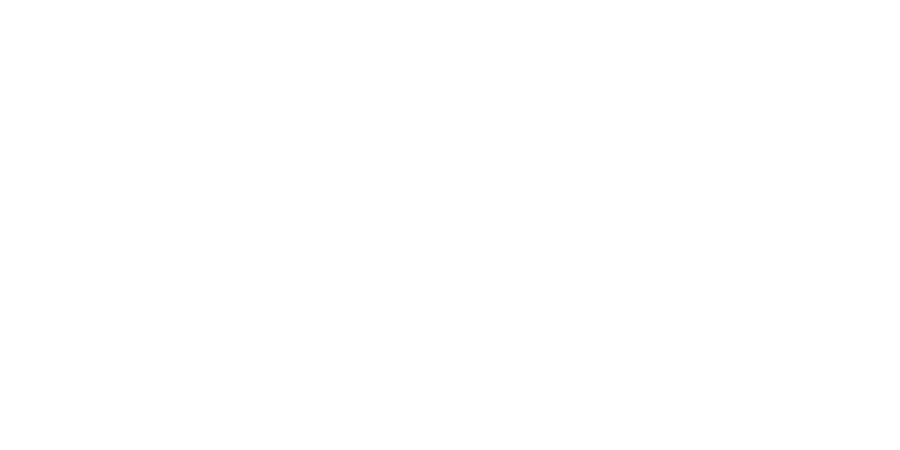

In [25]:
%matplotlib notebook

frame_rate = 15
window_before_sec = 2
window_after_sec = 2

fig, axes = plt.subplots(nrows=len(C_arrays), ncols=1, figsize=(12,6*(len(C_arrays))))
for index, (C_array, boris1, ax) in enumerate(zip(C_arrays, boris1s, axes)):
    if index!=2 and index !=3:
        plot_time_locked_responses(C_array, boris1, 'noncontact investigation',window_before_sec, window_after_sec, frame_rate, ax)
    else:
        plot_time_locked_responses(C_array, boris1, 'noncontact investigation right',window_before_sec, window_after_sec, frame_rate, ax)

    plt.tight_layout()
    
plt.show()

In [32]:
##CLICK THROUGH NEURONS TIME LOCKED TO BEHAVIOR, STERROR ACROSS TRIALS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def plot_neuron_response(matrix, behavior_df, behavior_name, frames_before=30, frames_after=30):
    # Filter the DataFrame based on the specified behavior name
    behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
    
    if behavior_data.empty:
        print(f"No data found for behavior '{behavior_name}'.")
        return

    # Extract the start and end frames for the specified behavior
    start_frames = behavior_data['scopeFrameStart'].values

    # Calculate the time points relative to the behavior event
    time_points = np.arange(-frames_before, frames_after + 1)

    # Calculate the time-locked responses for each neuron
    time_locked_responses = []
    for start_frame in start_frames:
        response_start = max(start_frame - frames_before, 0)
        response_end = min(start_frame + frames_after + 1, matrix.shape[1])
        response = matrix[:, response_start:response_end]
        response_padded = np.pad(response, ((0, 0), (max(0, frames_before - (start_frame - response_start)),
                                                 max(0, frames_after - (response_end - start_frame)))), 
                                 mode='constant', constant_values=np.nan)
        time_locked_responses.append(response_padded)

    if not time_locked_responses:
        print(f"No valid time-locked responses found for behavior '{behavior_name}'.")
        return

    # Calculate mean and standard deviation across all trials for each neuron
    mean_response = np.nanmedian(time_locked_responses, axis=0)
    std_response = np.nanstd(time_locked_responses, axis=0) / np.sqrt(len(time_locked_responses))


    # Create an interactive plot
    fig, ax = plt.subplots(figsize=(10, 6))

   # Initialize the plot with the first neuron
    neuron_idx = 0
    line_mean, = ax.plot(time_points, mean_response[neuron_idx], label=f'Neuron {neuron_idx + 1}')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)  # Vertical line at behavior onset
    ax.set_title(f"Mean and Standard Deviation of Neuron Responses to Behavior: '{behavior_name}'")
    ax.set_xlabel("Time Relative to Behavior Onset (Frames)")
    ax.set_ylabel("Neuron Response")
    ax.legend()
    ax.grid(True)

    def update_plot(neuron_idx):
        ax.clear()
        ax.scatter(time_points, mean_response[neuron_idx], label=f'Neuron {neuron_idx + 1}')
        ax.fill_between(time_points, mean_response[neuron_idx] - std_response[neuron_idx],
                    mean_response[neuron_idx] + std_response[neuron_idx], alpha=0.3)
        ax.set_title(f"Mean and Standard Deviation of Neuron Responses to Behavior: '{behavior_name}'")
        ax.set_xlabel("Time Relative to Behavior Onset (Frames)")
        ax.set_ylabel("Neuron Response")
        update_legend(neuron_idx)
        ax.figure.canvas.draw()

    def update_legend(neuron_idx):
        handles, labels = ax.get_legend_handles_labels()
        label = f'Neuron {neuron_idx + 1}'
        if label not in labels:
            handles.append(line_mean)
            labels.append(label)
        ax.legend(handles, labels)

    # Function to handle the key press event and update the neuron index
    def on_key(event):
        nonlocal neuron_idx
        if event.key == 'right':
            neuron_idx = min(neuron_idx + 1, matrix.shape[0] - 1)
        elif event.key == 'left':
            neuron_idx = max(neuron_idx - 1, 0)
        update_plot(neuron_idx)

    # Connect the update_plot function to the key press event
    fig.canvas.mpl_connect('key_press_event', on_key)

    plt.show()

In [ ]:
#import IPython

<IPython.core.display.Javascript object>


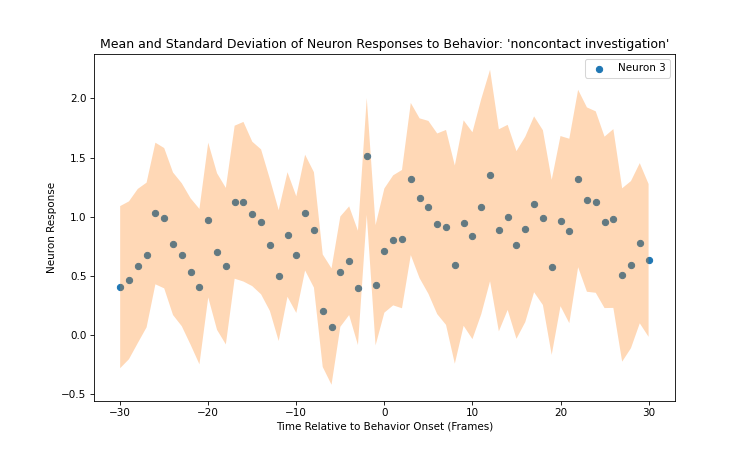

<IPython.core.display.Javascript object>


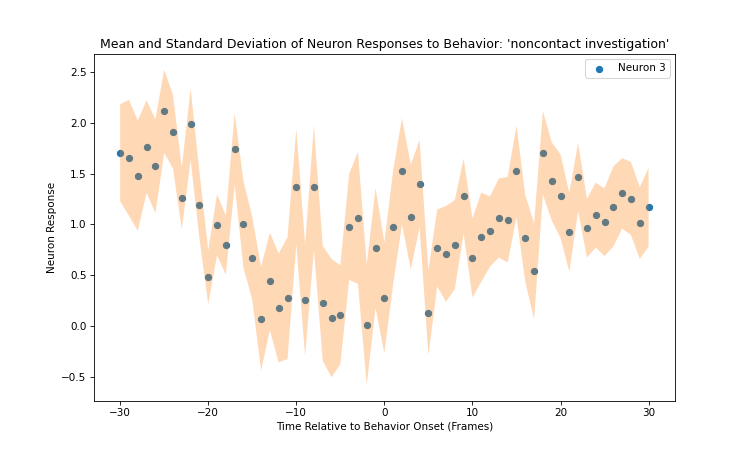

<IPython.core.display.Javascript object>


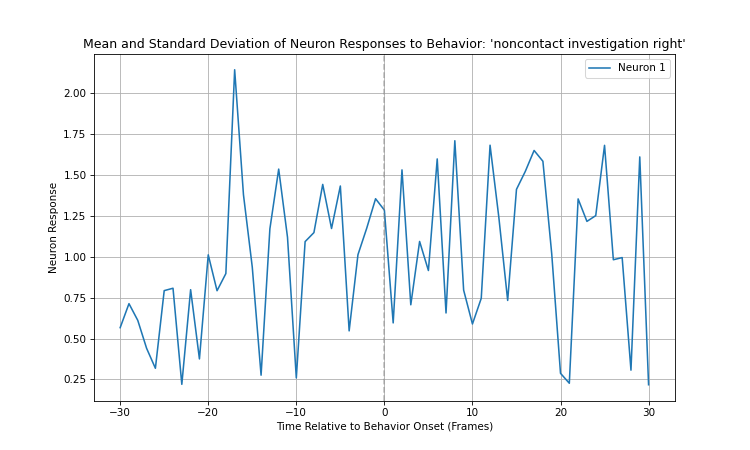

<IPython.core.display.Javascript object>


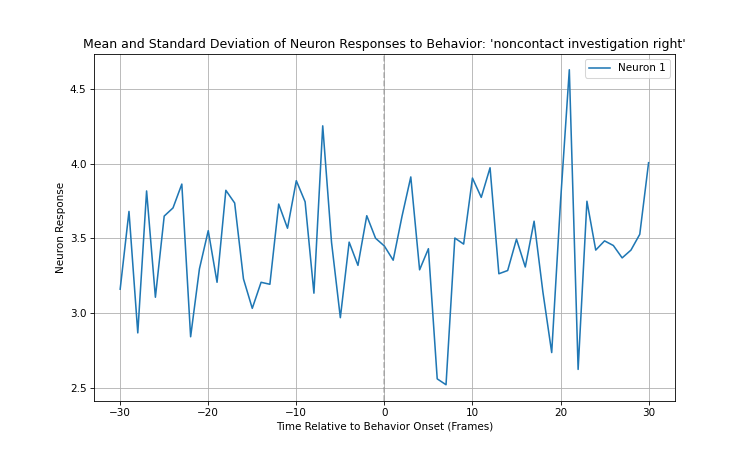

In [33]:

%matplotlib notebook

for index, (C_array, boris1) in enumerate(zip(C_arrays, boris1s)):
    if index!=2 and index!=3:
        plot_neuron_response(C_array, boris1, 'noncontact investigation')
    else:
        plot_neuron_response(C_array, boris1, 'noncontact investigation right')


In [34]:
import pdb
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

def find_significant_neurons(C_array, behavior_df, behavior_names, prestim_frames, poststim_frames, pvalueIn=0.01, secondFilter = None, cleversysFlag = None):
    # Initialize the output matrix
    num_neurons = C_array.shape[0]
    num_behaviors = len(behavior_names)
    significant_neurons = np.zeros((num_neurons, num_behaviors), dtype=int)
    behaviors_out = behavior_names
    # Loop through neurons and behaviors
    for neuron_idx in range(num_neurons):
        for behavior_idx, behavior_name in enumerate(behavior_names):
            # Filter the DataFrame based on the specified behavior name
            # Add option to filter based on second column as well 
            if cleversysFlag == 1:
                behavior_data = behavior_df[behavior_df['EventType'] == behavior_name]
            else:
                behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]


            if behavior_data.empty:
                #print(f"No data found for behavior '{behavior_name}'.")
                continue

            # Extract the start frames for the specified behavior
            start_frames = behavior_data['scopeFrameStart'].values

            # Calculate the prestimulus and poststimulus time points relative to the behavior event
            prestim_time_points = np.arange(-prestim_frames, 0)
            poststim_time_points = np.arange(1, poststim_frames + 1)

            # Align neuron's activity to the onset of each behavior and calculate prestimulus and poststimulus averages
            prestim_trials = []
            poststim_trials = []
            for start_frame in start_frames:
                prestim_start = max(start_frame - prestim_frames, 0)
                prestim_end = start_frame
                prestim_trials.append(C_array[neuron_idx, prestim_start:prestim_end])

                poststim_start = start_frame + 1
                poststim_end = min(start_frame + poststim_frames + 1, C_array.shape[1])
                poststim_trials.append(C_array[neuron_idx, poststim_start:poststim_end])

            # Calculate mean prestimulus and poststimulus responses across trials
            #pdb.set_trace()
            mean_prestim = np.median(prestim_trials, axis=1)
           # print(mean_prestim)
            mean_poststim = np.median(poststim_trials, axis=1)
           # print(mean_poststim)

            # Perform a paired t-test to compare poststimulus vs prestimulus activity
            _, p_value = ttest_rel(mean_poststim, mean_prestim)

            # Set the value in the output matrix based on the significance level (p < 0.05)
            if p_value < pvalueIn:
                significant_neurons[neuron_idx, behavior_idx] = 1

    return significant_neurons, behaviors_out

In [ ]:
#boris1s[2]

In [41]:
doBoris = 1
doCleversys = 1

behaviorsToAnalyze = ['noncontact investigation', 'contact investigation', 'grooming', 'lunge or bite',
     'mount', 'intromission', 'ejaculation']

behaviorsToAnalyzePPT = ['noncontact investigation right','noncontact investigation left', 'contact investigation right', 
                         'contact investigation left', 'grooming', 'lunge or bite',
                         'mount', 'intromission', 'ejaculation']

behaviorsToAnalyzeCleversys = ['Social Approach [ 1 to 3 ]','Social Approach [ 1 to 2 ]']

significant_neurons_group = []
behaviors_group = []
if doBoris==1:
    for index, (C_array, boris1) in enumerate(zip(C_arrays, boris1s)):
        # If day 0 or 1, use this code
        if index != 2 and index!= 3:
            significant_neurons_data, behaviors_out = find_significant_neurons(C_array, boris1, behaviorsToAnalyze, 15, 30, pvalueIn=0.01)
        else:
            significant_neurons_data, behaviors_out = find_significant_neurons(C_array, boris1, behaviorsToAnalyzePPT, 15, 30, pvalueIn=0.01)
        significant_neurons_group.append(significant_neurons_data)
        behaviors_group.append(behaviors_out)
    
if doCleversys==1:
    for index, (C_array, cv1) in enumerate(zip(C_arrays, cvs)):
    # If day 0 or 1, use this code
        if index==2: ##change this to add index==3 once I process cleveryss video
            significant_neurons_data, behaviors_out = find_significant_neurons(C_array, cv1, behaviorsToAnalyzeCleversys, 15, 30, pvalueIn=0.01, secondFilter = 'Right', cleversysFlag = 1)
    significant_neurons_group.append(significant_neurons_data)
    behaviors_group.append(behaviors_out)

In [ ]:
cleversysBehaviors

In [36]:
behaviors_group

[['noncontact investigation',
  'contact investigation',
  'grooming',
  'lunge or bite',
  'mount',
  'intromission',
  'ejaculation'],
 ['noncontact investigation',
  'contact investigation',
  'grooming',
  'lunge or bite',
  'mount',
  'intromission',
  'ejaculation'],
 ['noncontact investigation right',
  'noncontact investigation left',
  'contact investigation right',
  'contact investigation left',
  'grooming',
  'lunge or bite',
  'mount',
  'intromission',
  'ejaculation'],
 ['noncontact investigation right',
  'noncontact investigation left',
  'contact investigation right',
  'contact investigation left',
  'grooming',
  'lunge or bite',
  'mount',
  'intromission',
  'ejaculation'],
 ['Social Approach [ 1 to 3 ]', 'Social Approach [ 1 to 2 ]']]

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_behavior_bar_charts(significant_neurons_data, behaviors_out):
    # Calculate the percentage of neurons with 1s for each behavior
    percentages = np.mean(significant_neurons_data, axis=0) * 100

    # Plot a separate bar chart for each behavior
    plt.figure(figsize=(6, 6))
    plt.bar(behaviors_out, percentages, color='tab:blue', alpha=0.7)
    plt.xlabel('Behaviors')
    plt.ylabel('Percentage of Responsive Neurons (%)')
    plt.title('Percentage of Neurons Responsive to Each Behavior')
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.ylim([0, 50])
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


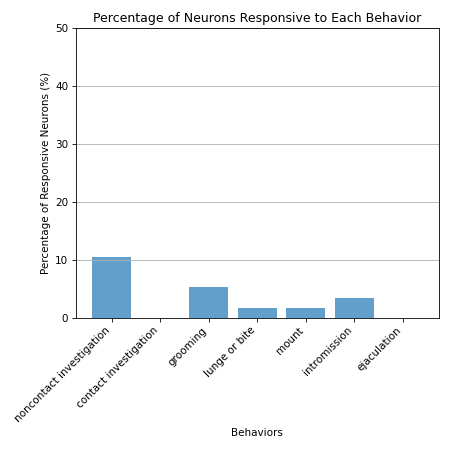

<IPython.core.display.Javascript object>


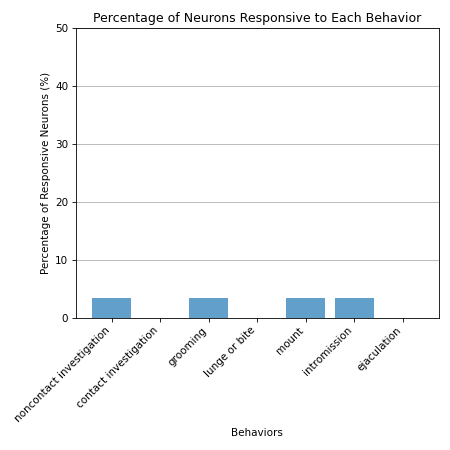

<IPython.core.display.Javascript object>


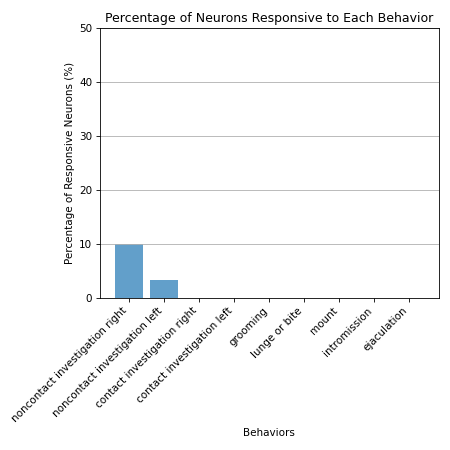

<IPython.core.display.Javascript object>


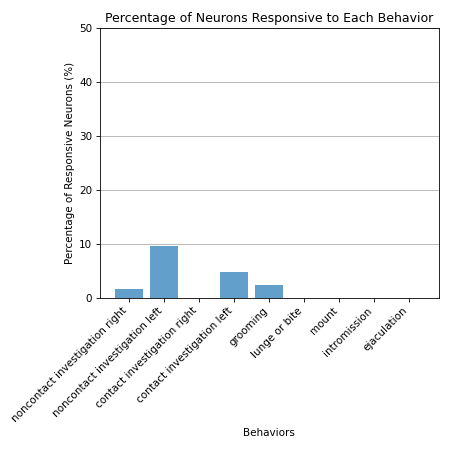

<IPython.core.display.Javascript object>


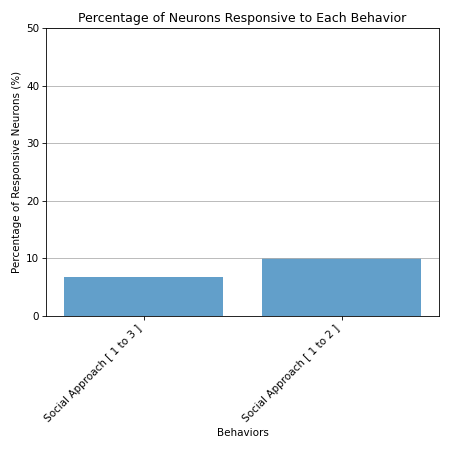

In [38]:
for index, (neurons, behaviors) in enumerate(zip(significant_neurons_group, behaviors_group)):
    plot_behavior_bar_charts(neurons, behaviors)



In [42]:
# Just a simple plotter to see what a single trace looks like over time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_one_row_with_shading(matrix_row, behavior_df, behavior_name):
    # Filter the behavior DataFrame for the specified behavior name
    behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
    start_frames = behavior_data['scopeFrameStart'].values
    end_frames = behavior_data['scopeFrameEnd'].values

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(np.arange(len(matrix_row)), matrix_row, color='b', lw=2, label='Signal')

    # Add shading for the specified behavior intervals
    for start_frame, end_frame in zip(start_frames, end_frames):
        ax.axvspan(start_frame, end_frame, alpha=0.3, color='yellow', label=behavior_name)

    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)  # Horizontal line at y=0

    ax.set_title("One-Row Plot with Shading")
    ax.set_xlabel("Time (in 10 min intervals)")
    ax.set_ylabel("Signal")
    ax.grid(True)
    # Set x-axis ticks at seconds intervals

    seconds_tick_interval = 9000  # Set the interval for seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=seconds_tick_interval))
    ax.set_xticklabels([0, 0, 10, 20, 30, 40, 50, 60])
    
    #ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


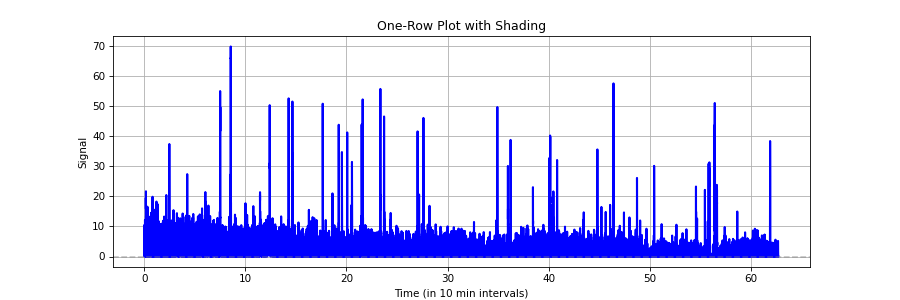

C:\Users\ephys\AppData\Local\Temp\ipykernel_12344\254220890.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0, 10, 20, 30, 40, 50, 60])


In [43]:
%matplotlib notebook
row_to_plot = 3
plot_one_row_with_shading(C_array[row_to_plot,:], boris1, 'noncontact investigation')

In [44]:
## PAIRWISE CORRELATIONS, TIME LOCKED TO ONSET
# 1 SEC WINDOWS, SLIDING BY 0.33 SEC

import numpy as np
import pandas as pd
from scipy.stats import sem
import pdb

def calculate_mean_pairwise_correlations(matrix, behavior_df, behaviors_to_filter, prestim_frames, poststim_frames, frame_rate=15, cleversysFlag=0):
    # Function to calculate average pairwise correlations for a given time range
    def calculate_pairwise_correlations(data, start_frame, end_frame):
        #pdb.set_trace()
        time_range_data = data[:, start_frame:end_frame]
        pairwise_correlations = np.corrcoef(time_range_data)
        np.fill_diagonal(pairwise_correlations, np.nan)
        return np.nanmean(pairwise_correlations)

    # Filter the DataFrame based on the specified behaviors
    if cleversysFlag==0:
        filtered_df = behavior_df[behavior_df['Behavior'].isin(behaviors_to_filter)]
    else:
        filtered_df = behavior_df[behavior_df['EventType'].isin(behaviors_to_filter)]

    # Calculate time range in seconds
    prestim_time = prestim_frames / frame_rate
    poststim_time = poststim_frames / frame_rate

    # Initialize a dictionary to store results for each behavior
    results = {}

    # Loop through each behavior
    for behavior in behaviors_to_filter:
        # Get the behavior data
        if cleversysFlag==0:
            behavior_data = filtered_df[filtered_df['Behavior'] == behavior]
        else:
            behavior_data = filtered_df[filtered_df['EventType'] == behavior]

        # Initialize lists to store pairwise correlations for each instance of behavior
        correlations = []

        # Loop through each instance of behavior
        for _, row in behavior_data.iterrows():
            # Start with prestim_frames before the behavior onset
            start_frame = row['scopeFrameStart'] - prestim_frames
            end_frame = start_frame + 15  # 15 frames wide window

            instance_correlations = []
            # Continue sliding the window by 3 frames until we reach poststim_frames
            while end_frame <= row['scopeFrameStart'] + poststim_frames:
                avg_corr = calculate_pairwise_correlations(matrix, start_frame, end_frame)
                instance_correlations.append(avg_corr)

                # Move the window forward by 3 frames
                start_frame += 3
                end_frame += 3

            correlations.append(instance_correlations)
            
        #pdb.set_trace()

        # Calculate mean and standard error of pairwise correlations for this behavior
        mean_corr = np.nanmean(correlations, axis=0)
        std_err_corr = sem(correlations, axis=0)

        # Store results in the dictionary
        results[behavior] = {'mean_corr': mean_corr, 'std_err_corr': std_err_corr}

    return results

In [45]:
xcorr_results = {}
for i, (C_array, boris1) in enumerate(zip(C_arrays, boris1s)):
    if i!=2 and i!=3:
        xcorr_result = calculate_mean_pairwise_correlations(C_array, boris1, ['noncontact investigation'], 15, 30)
    else:
        xcorr_result = calculate_mean_pairwise_correlations(C_array, boris1, ['noncontact investigation right'], 15, 30) 
    xcorr_results[f'result_{i}'] = xcorr_result
print(xcorr_results)

C:\Users\ephys\miniconda3\envs\scratch\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\ephys\miniconda3\envs\scratch\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'result_0': {'noncontact investigation': {'mean_corr': array([-6.74702356e-05,  2.82497533e-04,  1.23490484e-04, -4.61647828e-04,
        5.87598375e-04,  1.09695057e-03,  1.47630760e-03,  1.18821225e-03,
        4.85789476e-04,  4.00775519e-04,  2.37940063e-04]), 'std_err_corr': array([0.00069118, 0.00071954, 0.00072414, 0.00064177, 0.00076056,
       0.00075841, 0.0007938 , 0.00073593, 0.00067448, 0.00074128,
       0.00075158])}}, 'result_1': {'noncontact investigation': {'mean_corr': array([ 1.05032833e-03,  1.54503290e-03,  1.05868596e-03, -1.08686350e-03,
       -4.67298668e-04,  3.35889865e-05, -8.60445337e-04, -5.19981787e-04,
        3.01077273e-04, -8.69352538e-04, -1.07384355e-03]), 'std_err_corr': array([0.00132229, 0.00132063, 0.00088687, 0.00083265, 0.00096927,
       0.00094426, 0.00089918, 0.00108375, 0.00115536, 0.00113872,
       0.00100049])}}, 'result_2': {'noncontact investigation right': {'mean_corr': array([-0.00044284,  0.00011535, -0.00034561, -0.00013615,  0.

In [ ]:
#results_right = calculate_mean_pairwise_correlations(C_arrays[2], cvs[2], ['Social Approach [ 1 to 3 ]'], 15, 30, cleversysFlag=1)
#print(results)
#results_left = calculate_mean_pairwise_correlations(C_arrays[2], cvs[2], ['Social Approach [ 1 to 2 ]'], 15, 30, cleversysFlag=1)
#print(results_left)


In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_xcorr_results(results, results_to_plot, behaviorToGet):
    # Calculate the number of subplots based on the number of entries in 'results_to_plot'
    num_subplots = len(results_to_plot)

    # Create a figure and axes for each subplot
    fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 6 * num_subplots), sharex=True)

    # Loop through each behavior to plot
    for i, behavior_key in enumerate(results_to_plot.keys()):
        # Check if the behavior key exists in 'results'
        if behavior_key in results:
            # Get the data for the behavior from 'results' dictionary
            behavior_data = results[behavior_key].get('noncontact investigation right', None)

            # Check if the required data keys are present
            if behavior_data is not None and 'mean_corr' in behavior_data and 'std_err_corr' in behavior_data:
                mean_corr = behavior_data['mean_corr']
                std_err_corr = behavior_data['std_err_corr']

                # Calculate the x-axis tick positions and labels
                x_ticks = np.arange(1, len(mean_corr) + 1)

                # Plot the mean correlations with error bars
                axs[i].errorbar(x_ticks, mean_corr, yerr=std_err_corr, marker='o', linestyle='-', capsize=5)
                axs[i].set_title(results_to_plot[behavior_key])
                axs[i].grid(True)
                xtick_values = np.round(np.linspace(-0.5,1.5,11),1)
                xtick_labels = [str(value) for value in xtick_values]
                x_ticks = range(1,len(xtick_values) + 1)
                axs[i].set_xticks(x_ticks)
                axs[i].set_xticklabels(xtick_labels)
                #plt.xticks(x_ticks, x_tick_labels)

            else:
                axs[i].set_title(f"Behavior '{results_to_plot[behavior_key]}' does not have 'mean_corr' or 'std_err_corr' data.")
                axs[i].grid(True)
        else:
            axs[i].set_title(f"Behavior '{results_to_plot[behavior_key]}' not found in 'results'.")
            axs[i].grid(True)

    # Set x-axis label for the last subplot (shared across all subplots)
    axs[-1].set_xlabel('Secs relative to onset')

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


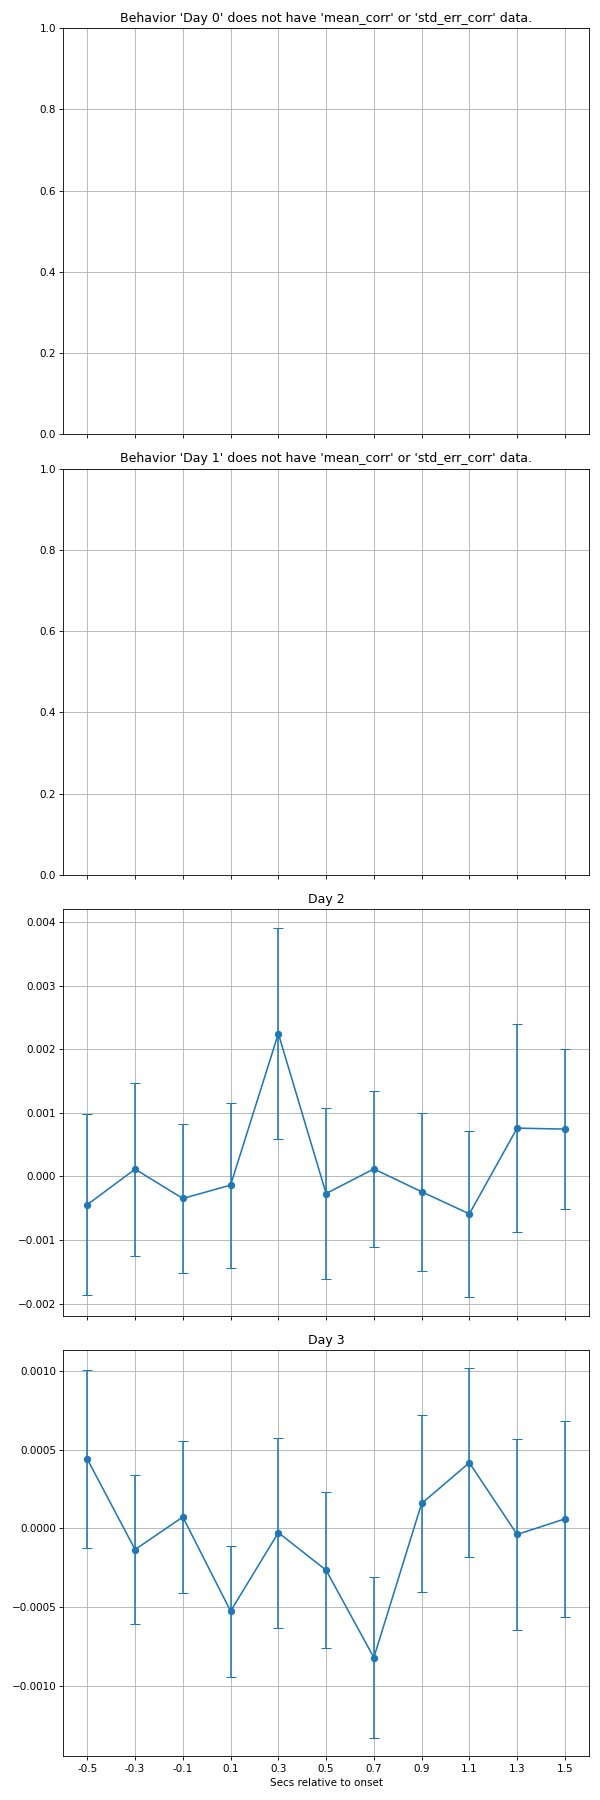

In [52]:
xcorr_results_to_plot = {
    'result_0': 'Day 0',
    'result_1': 'Day 1',
    'result_2': "Day 2",
    'result_3': 'Day 3'
}

plot_xcorr_results(xcorr_results, xcorr_results_to_plot, behaviorToGet='noncontact investigation right')

In [ ]:
#help(plt.errorbar)

In [ ]:
## Analysis idea - lets separate non-contact and contact by investigating or receiving

In [53]:
# Need to add option to separate this into left and right

import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd

def get_behavior_onsets(behavior_data, num_frames):
    onsets = np.zeros(num_frames)
    for _, row in behavior_data.iterrows():
        onsets[row['scopeFrameStart']:row['scopeFrameEnd'] + 1] = 1

    return onsets

def calculate_auroc_with_shuffling(matrix, behavior_df, behavior_names, num_shuffles=1000, cleversysFlag=0):
    num_neurons = matrix.shape[0]
    num_behaviors = len(behavior_names)
    auroc_matrix = np.zeros((num_neurons, num_behaviors))
    p_value_matrix = np.zeros((num_neurons, num_behaviors))

    for i in range(num_neurons):
        neuron_data = matrix[i, :]
        print(i)

        for j, behavior_name in enumerate(behavior_names):
            if cleversysFlag==0:
                behavior_data = behavior_df[behavior_df['Behavior'] == behavior_name]
            else:
                behavior_data = behavior_df[behavior_df['EventType'] == behavior_name]

            if behavior_data.empty:
                print(f"No data found for behavior '{behavior_name}' for neuron {i + 1}.")
                continue

            behavior_onsets = get_behavior_onsets(behavior_data, matrix.shape[1])

            true_auroc = roc_auc_score(behavior_onsets, neuron_data)

            # Shuffle scopeStartTime and scopeEndTime
            shuffled_aurocs = []
            for _ in range(num_shuffles):
                shuffled_behavior_data = behavior_data.copy()
                shuffled_behavior_data['scopeFrameStart'] = np.random.randint(0, matrix.shape[1] - 1, len(behavior_data))
                shuffled_behavior_data['scopeFrameEnd'] = shuffled_behavior_data['scopeFrameStart'] + (behavior_data['scopeFrameEnd'] - behavior_data['scopeFrameStart']).values
                behavior_onsets_shuffled = get_behavior_onsets(shuffled_behavior_data, matrix.shape[1])
                #print(behavior_onsets_shuffled)
                shuffled_aurocs.append(roc_auc_score(behavior_onsets_shuffled, neuron_data))

            auroc_matrix[i, j] = true_auroc
            p_value_matrix[i, j] = (np.sum(shuffled_aurocs >= true_auroc) + 1) / (num_shuffles + 1)

    return auroc_matrix, p_value_matrix

In [55]:
## Lets save a pickle file with everything we want for this animal

with open(save_dir, 'wb') as file:
    pickle.dump([significant_neurons_data, behaviors_out, auROC_matrix, p_value_matrix, xcorr_results], file)


NameError: name 'auROC_matrix' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_and_plot_behavior_distribution(matrix, behavior_df, behavior_list):
    # Transpose the matrix to have frames as rows and neurons (cells) as columns
    matrix_transposed = matrix.T

    # Initialize empty arrays to store PC values for each behavior
    pc1_values = np.array([])
    pc2_values = np.array([])

    # Perform PCA on the transposed matrix
    pca = PCA(n_components=2)
    transformed_matrix = pca.fit_transform(matrix_transposed)

    # Loop through each behavior in the behavior_list
    for behavior in behavior_list:
        # Filter the behavior_df to get the frames within the specified behavior range
        behavior_frames_df = behavior_df[(behavior_df['Behavior'] == behavior)]
        for _, row in behavior_frames_df.iterrows():
            start_frame = row['scopeFrameStart']
            end_frame = row['scopeFrameEnd']
            frames_in_behavior = np.arange(start_frame, end_frame + 1)
            # Extract the PC values for the frames within the specified behavior range
            pc1_behavior = transformed_matrix[frames_in_behavior, 0]
            pc2_behavior = transformed_matrix[frames_in_behavior, 1]
            # Append the PC values for the current behavior to the overall PC arrays
            pc1_values = np.append(pc1_values, pc1_behavior)
            pc2_values = np.append(pc2_values, pc2_behavior)

    # Plot the distribution of frames for each behavior
    plt.figure(figsize=(10, 6))
    for behavior in behavior_list:
        behavior_frames_df = behavior_df[(behavior_df['Behavior'] == behavior)]
        for _, row in behavior_frames_df.iterrows():
            start_frame = row['scopeFrameStart']
            end_frame = row['scopeFrameEnd']
            plt.scatter(pc1_values[start_frame:end_frame + 1], pc2_values[start_frame:end_frame + 1], label=behavior)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Distribution of Frames for Each Behavior')
    plt.legend()
    plt.grid(True)
    plt.show()




In [ ]:
pca_and_plot_behavior_distribution(matrix, behavior_df, behavior_list)


In [ ]:
import pandas as pd
import os
import re
import pdb #for debugging
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import auc
import pickle
import holoviews as hv
import numpy as np
import xarray as xr
import random

%load_ext autoreload
%autoreload 2


# ideally loop through multiple directories, load variables into single object per animal,
# and then have core functions to loop the objects through, with a plotter that
# pulls the outputs together 


day0 = "C://miniscopeData/5546/2022_12_15/13_56_20_record/12152022_cohabitation_5546"
day1 = "C://miniscopeData/5546/2022_12_16/14_36_12/121622_cohousing_5546"
day2 = "C://miniscopeData/5546/2022_12_17/12_48_22"
partner="Left"
novel="Right"
runPartner1OrNovel0 = 0

day14 = "C://miniscopeData/5546/2023_01_01/13_17_27/01012023_PPTnodrug"
partnerDay14="Right"
novelDay14="Left"


mainDir = day0
mainDirName = 'day0'

loadDir = os.path.join(mainDir + '/alignerOutput')


generalOutDir = "C://miniscopeData/5546"
writeOutDir = os.path.join(generalOutDir + '/analysesOutput')
isExist = os.path.exists(writeOutDir)
if not isExist:
    os.makedirs(writeOutDir)



with open(os.path.join(loadDir + '/minianOut.pkl'), 'rb') as f:
    cellsKept, cellsKeptSpikes, cv,boris1 = pickle.load(f)
    
#cellsKept, cellsKeptSpikes, cv, boris1


In [ ]:
#scratch cell, to look at downsampling of Minian, to make sure indices are appropriate
#temporal downsampling by 2 on Minian, so this should also be 2
#also transposes for corr matrix and PCA cells

columnNames = cellsKept.columns
numMinianFrames = max(columnNames)
numMinianDownsample = cellsKept.shape[1]

downsampleFactor = numMinianFrames / numMinianDownsample
print(downsampleFactor)

dsFactorUsed = 2

#print(numMinianFrames)

cellsKept.shape[0]
cellsTransposed = cellsKept.transpose()


#print(cellsKept.shape[1])
#cellsKept.iloc[(cellsKept['frame']-32).abs().argsort()[:1]]

In [ ]:
cellsKept

In [ ]:
#CORR MATRIX ACROSS SESSION

import seaborn as sns 
#print(cellsTransposed)
matrix = cellsTransposed.corr()
mask_ut = np.triu(np.ones(matrix.shape)).astype(bool)
fig = plt.figure()
hmap = sns.heatmap(matrix,mask=mask_ut,vmin=-1,vmax=1,cmap="Spectral")

fileName = mainDirName + 'overallCorrMatrix.png'
saveFolder = os.path.join(writeOutDir,'corrMatrix/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName
fig.savefig(saveName)

#print(matrix)
#plt.matshow(matrix)
#plt.show()

In [ ]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

cellsKept = z_score(cellsKept)

print(cellsKept.ndim)

In [ ]:
#PCA ACROSS SESSION

#pip install pca

from pca import pca
import numpy as np
from sklearn.preprocessing import StandardScaler
  
    
def center(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=False)
    Xc = ss.fit_transform(X.T).T
    return Xc


#cellsKeptCentered = center(cellsTransposed)
#cellsKeptCenteredTransposed = cellsKeptCentered.transpose()



model = pca(n_components=0.99, normalize=True)
results = model.fit_transform(cellsTransposed)
fig,ax = model.plot()

# Make scatterplot
#model.scatter()

# Gradient over the samples. High dense areas will be more colourful.
#model.scatter(gradient='#FFFFFF')

# Include the outlier detection
#model.scatter(SPE=True)

# Include the outlier detection
#model.scatter(hotellingt2=True)

# Look at different PCs: 1st PC=1  vs PC=3
#model.scatter(PC=[0, 2])

#fileName = mainDirName + 'overallPCA.png'
#saveFolder = os.path.join(writeOutDir,'PCA/')

#isExist = os.path.exists(saveFolder)
#if not isExist:
#    os.makedirs(saveFolder)
    
#saveName = saveFolder + fileName
#fig.savefig(saveName)

In [ ]:
def runPCA(matrixIn,directory):
    model = pca(n_components=0.95)
    results = model.fit_transform(matrixIn)
    fig,ax = model.plot()
    fig.savefig(directory)


In [ ]:
boris1.Behavior
behaviorUniques = list(set([car for car in boris1.Behavior]))
behaviorUniques





## optional cell for warping behavior and neural data to accomodate equal event totals

# modify boris1. 





In [ ]:
#pulling out events and corresponding data 

behaviorOfInterestCleversys = 'Social Approach' #cleversys-defined social contact
#behaviorOfInterestCleversys = '1 to 2' #cleversys-defined social approach 1 to 2

behaviorOfInterestBoris = 'contact investigation' #boris-defined contact investigation
#behaviorOfInterestBoris = '' #boris-defined contact investigation


Boris1OrCleversys0 = 1
plotCells1OrSpikes0 = 0

if plotCells1OrSpikes0 == 1:
    dataUsed = cellsKept
else:
    dataUsed = cellsKeptSpikes


socialCv = cv[cv.EventType.str.contains(behaviorOfInterestCleversys)]
#socialCv = socialCv[(socialCv.LengthinSec > 1)] #limit to >1sec bouts
socialCv = socialCv.tail(-1)
#print(socialCv)

upsampleNovel = 0

boris1.rename(columns={'Behavioral category': 'BehavioralCategory'},inplace=True)
socialCvBoris = boris1[boris1.Behavior.str.contains(behaviorOfInterestBoris)]
socialCvBoris = socialCvBoris[socialCvBoris.Behavior.str.contains(behaviorOfInterestBoris)]
#socialCvBoris = socialCvBoris[socialCvBoris.BehavioralCategory.str.contains('Affiliative')]


#socialCvBoris = socialCvBoris[(socialCvBoris['Duration (s)'] > 1)]
if mainDir == day2:
    socialCvBorisNovel = socialCvBoris[socialCvBoris.Subject.str.contains(novel)]
    socialCvBorisPartner = socialCvBoris[socialCvBoris.Subject.str.contains(partner)]
    if runPartner1OrNovel0==1:
        socialCvBoris = socialCvBorisPartner
    elif runPartner1OrNovel0==0:
        socialCvBoris = socialCvBorisNovel
        
    upsampleNovel = 1 
    #socialCvBoris = socialCvBoris[socialCvBoris.Behavior.str.contains('noncontact')]
elif mainDir == day14:
    socialCvBoris = socialCvBoris[socialCvBoris.Subject.str.contains(novel)]
socialCvBoris = socialCvBoris.tail(-1)
if Boris1OrCleversys0==1:
    socialCv = socialCvBoris
    behaviorOfInterest = behaviorOfInterestBoris

numBeforeEvent = 20
numAfterEvent = 30
numTotal = numBeforeEvent + numAfterEvent
socialContactC = np.zeros([dataUsed.shape[0],numTotal,socialCv.shape[0]])
print(socialContactC.shape)


for ev in range(socialCv.shape[0]):
    if Boris1OrCleversys0 == 0:
        scopeFrameStart = socialCv.iloc[ev,9]
    else: 
        scopeFrameStart = socialCv.iloc[ev,18]
        
    minianFrameStart = scopeFrameStart/dsFactorUsed
    minianFrameStart = round(minianFrameStart)
    if Boris1OrCleversys0 == 0:
        scopeFrameEnd = socialCv.iloc[ev,10]
    else:
        scopeFrameEnd = socialCv.iloc[ev,19]
    minianFrameEnd = scopeFrameEnd/dsFactorUsed
    minianFrameEnd = round(minianFrameEnd)
    #try: #to account for events happening too close to end
    socialContactC[:,0:numBeforeEvent-1,ev] = dataUsed.iloc[:,minianFrameStart-numBeforeEvent:minianFrameStart-1]
    socialContactC[:,numBeforeEvent-1:numTotal,ev] = dataUsed.iloc[:,minianFrameStart:minianFrameStart+numAfterEvent+1] 
    #except:
        #pass
    
    
#socialContactC = np.nanmean(socialContactC,axis=2) #nanmean across bouts
#print(socialCvBoris)
#socialCvBoris.sum(' Duration (s)')



total = socialCvBoris['Duration (s)'].sum()
print(total)

#socialCvBoris


In [ ]:
import Assemblies_MEK
dataUsedDf = dataUsed.to_numpy()
np.shape(dataUsedDf)

In [ ]:
import importlib
importlib.reload(Assemblies_MEK)
assembly_dict, fig, axs = Assemblies_MEK.find_assemblies(dataUsedDf,method='ica',nullhyp='mp',n_shuffles=1000,percentile=99,tracywidow=False,
                              compute_activity=True, use_bool=False, plot=True)
#assembly_dict has patterns, significance, z_data, orig_data, and activations

   
fileName = mainDirName + 'assemblies_spikes.png'

saveFolder = os.path.join(writeOutDir,'assemblies/')

print(len(assembly_dict['activations']))

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName

#fig.savefig(saveName)

In [ ]:
patterns = assembly_dict['patterns']
activations = assembly_dict['activations']
sorted_spiking = assembly_dict['sorted_spiking']
sorted_colors = assembly_dict['sorted_colors']

print(activations.shape)


fig,axs = Assemblies_MEK.plot_assemblies_select(activations, sorted_spiking, colors=sorted_colors)


fileName = mainDirName + 'assemblies_spikes_example.png'

saveFolder = os.path.join(writeOutDir,'assemblies/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName


#with open(os.path.join(saveFolder + '\_5546_day0.pkl'), 'wb') as f:
    #pickle.dump([assembly_dict], f)

In [ ]:
# 1) try warping novel events using nearest neighbor to equalize the num of frames for each event type
# 2) using total novel time, subsample partner time & remove other frames

import statistics 

totalSession = boris1['Duration (s)'].sum()
#print(totalSession)

totalPartner = socialCvBorisPartner['Duration (s)'].sum()
totalNovel = socialCvBorisNovel['Duration (s)'].sum()
novelTimeToAddTotal = (totalPartner-totalNovel)
#print(middlePoint)

# divide amount of necessary added time by # events to add that time to
#novelTimeToAdd = middlePoint - totalNovel
#partnerTimeToSubtract = totalPartner - middlePoint

#print(len(socialCvBorisPartner))
#print(len(socialCvBorisNovel))
novelTimeToAdd = novelTimeToAddTotal / len(socialCvBorisNovel)
#partnerTimeToSubtract = partnerTimeToSubtract / len(socialCvBorisPartner)
#print(novelTimeToAdd)
#print(partnerTimeToSubtract)


# find avg conversion between behavior frame #s and minian frame #s. use that 
differenceFrameNums = socialCvBorisNovel.iloc[:,17] - socialCvBorisNovel.iloc[:,16]
differenceScopeNums = socialCvBorisNovel.iloc[:,19] - socialCvBorisNovel.iloc[:,18]
avgConversion = np.mean(differenceScopeNums / differenceFrameNums)


#bug - newMinianLength changes with every event, so cant be set in stone here
#but if I write it back into dataUsed, then the indices for that change..
newCell = np.zeros((len(tempData),dataUsed.shape[1]+(novelTimeToAddTotal*avgConversion),socialCvBorisNovel.shape[0]))
                   
#print(socialCvBorisNovel.shape[0])
#print(newMinianLength)

for ev in [0]:#range(socialCvBorisNovel.shape[0]):

    # pull out cam and scope frame indices
    camFrameStart = socialCvBorisNovel.iloc[ev,16]
    camFrameStop = socialCvBorisNovel.iloc[ev,17]
    scopeFrameStart = socialCvBorisNovel.iloc[ev,18]
    scopeFrameEnd = socialCvBorisNovel.iloc[ev,19]

    #display(socialCvBorisNovel.iloc[0:5,:])

    #convert seconds into frames to add
    framesToAdd = novelTimeToAdd * 50
    # add new behavior frames. these will become 1s downstream
    newEnd = (round(camFrameStop+framesToAdd))
    socialCvBorisNovel.iloc[ev,17] = newEnd
        # adjust the rest of the frames to account for this change
    socialCvBorisNovel.iloc[ev+1:-1,16] = socialCvBorisNovel.iloc[ev+1:-1,16] + int(framesToAdd)
    socialCvBorisNovel.iloc[ev+1:-1,17] = socialCvBorisNovel.iloc[ev+1:-1,17] + int(framesToAdd)

    # now go into neural data and interpolate to warp equivalent amount of neural data

    # find new minianFrameStart and minianFrameEnd
    # go into dataUsed and interpolate it, making dataUsed larger
    scopeFramesToAdd = int(framesToAdd * avgConversion)
    newScopeFrameEnd = scopeFrameEnd + scopeFramesToAdd
    socialCvBorisNovel.iloc[ev,19] = newScopeFrameEnd

    # adjust the rest of the frames to account for this change
    # when indexed in the future, it will ultimately point to a modified dataUsed that has new frames
    socialCvBorisNovel.iloc[ev+1:-1,18] = socialCvBorisNovel.iloc[ev+1:-1,18] + int(scopeFramesToAdd)
    socialCvBorisNovel.iloc[ev+1:-1,19] = socialCvBorisNovel.iloc[ev+1:-1,19] + int(scopeFramesToAdd)

    # get the typical minian frame indices
    minianFrameStart = scopeFrameStart/dsFactorUsed
    minianFrameStart = round(minianFrameStart)
    minianFrameEnd = scopeFrameEnd/dsFactorUsed
    minianFrameEnd = round(minianFrameEnd)


    # get new minian frame end index, and new length of data
    newMinianFrameEnd = round(newScopeFrameEnd / dsFactorUsed)
    newMinianLength = newMinianFrameEnd - minianFrameStart
    existingMinianLength = minianFrameEnd - minianFrameStart


    print(newMinianLength)
    print(existingMinianLength)

    # pull out the existing data
    tempData = dataUsed.iloc[:,minianFrameStart:minianFrameEnd]


    #Initialize new numpy matrix for cells with new length of data
    newCell = np.zeros((len(tempData),newMinianLength))

    # loop through cells
    for cell in [0]:#[0]:#range(len(dataUsed)):
        #print(cell)
        tempDataCell = tempData.iloc[cell,:] 


        # to determine how many times to repeat Minian values 
        multiplyFactor = (round(newMinianLength/existingMinianLength))
        #print(multiplyFactor)

    
        tempDataCell = tempDataCell.to_numpy()
        tempDataCell = np.repeat(tempDataCell,multiplyFactor+1,axis=0)

        #print(newMinianLength)

        #now, take out the # of frames that we overshot by
        #shitty way to do it
        change = (len(tempDataCell) - newMinianLength)
        randDelete = random.sample(range(0,len(tempDataCell)),change)
        tempDataCell = np.delete(tempDataCell,randDelete)
        #print(len(tempDataCell))

        # insert into array
        newCell[cell,:] = tempDataCell

        #tempDataCell  = pd.DataFrame(tempDataCell)
        #tempData.iloc[cell,:] = tempDataCell
        #dataWriteIn = newCell[cell,0:existingMinianLength]
        
        
        #len(dataWriteIn.columns)
        
        #dataWriteIn = newCell.reshape((existingMinianLength,))
        #dataWriteIn = pd.DataFrame(newCell[cell,0:existingMinianLength])
        #dataWriteIn = pd.DataFrame(dataWriteIn)
        #dataWriteIn = dataWriteIn.reshape((existingMinianLength,))
    dataWriteIn = newCell[:,0:existingMinianLength]
    print(dataWriteIn.shape)
    dataUsed.iloc[:,minianFrameStart:minianFrameEnd] = dataWriteIn
    
    print(dataUsed.shape)
        
    # now for anything beyond existing MinianLength, need to expand the # of columns
    numRemaining = newMinianLength - existingMinianLength
    remainingData = newCell[:,-numRemaining:]
    numSamples = (remainingData.shape[0])
    #print(minianFrameEnd+1)
    #print(minianFrameEnd+1+numSamples)
    #print([minianFrameEnd+1:minianFrameEnd+1+numSamples])
    #dataUsed.insert(minianFrameEnd+1:minianFrameEnd+1+remainingData.shape,[],remainingData)
    #dataUsed.insert[cell,minianFrameEnd+1,'columns'] = remainingData    
    #display(pd.DataFrame(remainingData))
    
    
    
    print(remainingData.shape)
    print(dataUsed.shape)
    
    
    remainingData = pd.DataFrame(remainingData)
    unitIdNames = (dataUsed.index)
    remainingData.index = unitIdNames
    
    dataUsed = dataUsed.join(remainingData,rsuffix='_')





In [ ]:
#display(dataUsed)
print(remainingData.shape)
print(dataWriteIn.shape)
print(unitIdNames)

#dataUsed2 = dataUsed.join(remainingData,rsuffix='_')
#print(dataUsed2.shape)
display(dataUsed)

## BEHAVIOR SPECIFIC PCA
socialContactC_acrossCells = np.nanmean(socialContactC,axis=2) #nanmean across bouts
socialContactC_acrossCells = socialContactC_acrossCells.transpose()
model = pca(n_components=0.95)
results = model.fit_transform(socialContactC_acrossCells)
fig,ax = model.plot()

fileName = mainDirName + 'BehaviorPCA.png'
if mainDir == day2:
    fileName = mainDirName + 'NovelBehaviorPCA.png'
elif mainDir == day14:
    fileName = mainDirName + 'PartnerBehaviorPCA.png'
    

saveFolder = os.path.join(writeOutDir,'PCA/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName
fig.savefig(saveName)

#fig.savefig(directory)

In [ ]:
#function for running AUC shuffles
def auROCshuffle(cellActivity):
    cellActivityZScore = stats.zscore(cellActivity)

    # initialize TPR and FPR for each of the 100 steps
    TPR_cell = [0] * 100
    FPR_cell = [0] * 100

    #max(cellActivityZScore)
    #min(cellActivityZScore)

    # define 100 steps of z-scored DF/F
    steps = np.linspace(min(cellActivityZScore),max(cellActivityZScore),num=100)

    for st in range(len(steps)):
        # iter through steps, calculate metrics, aggregate
        indices = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] >= steps[st]]
        indicesBelow = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] < steps[st]]
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for ind in range(len(indices)):
            behaviorPresence  = contactBinary[indices[ind]]
            if behaviorPresence==1:
                TP = TP + 1
            if behaviorPresence==0:
                FP = FP + 1
    
        for indBelow in range(len(indicesBelow)):
            behaviorPresence = contactBinary[indicesBelow[indBelow]]
            if behaviorPresence==1:
                FN = FN + 1
            if behaviorPresence==0:
                TN = TN + 1
        #try:
        TPR_cell[st] = TP / (TP + FN)
        #except:
            #sometimes TPR is dividing by 0 b/c at a given threshold, there were no true positives and no false negatives yet
            #TPR_cell[st] = 0
            #print(st)
            #print(ind)
        if doPRC==0:
            FPR_cell[st] = FP / (FP + TN)
        elif doPRC==1:
            FPR_cell[st] = TP / (TP + FP) #actually precision

    # plot AUCs on top of one another and write out AUC
    #plt.plot(FPR_cell,TPR_cell,'b')
    if doPRC==1:
        AUC_shuffles = auc(TPR_cell,FPR_cell)
    elif doPRC==0:
        AUC_shuffles = auc(FPR_cell,TPR_cell)
    
    return AUC_shuffles

In [ ]:
print(cellsKept.shape)
print(activations.shape)
cellsKept = pd.DataFrame(activations)

In [ ]:
runShuffle = 1
doPRC = 1
import nn_interpolate

#construct binary vector of behavior yes/no
contactBinary = [0] * numMinianDownsample

from collections import deque
from random import randint

# go through behaviors, find the minian frames they align to, and assign those as 1s
for ev in range(socialCv.shape[0]):
    if Boris1OrCleversys0 == 0:
        scopeFrameStart = socialCv.iloc[ev,9] #this is 
    else: 
        scopeFrameStart = socialCv.iloc[ev,18]
        
    minianFrameStart = scopeFrameStart/dsFactorUsed
    minianFrameStart = round(minianFrameStart)
    if Boris1OrCleversys0 == 0:
        scopeFrameEnd = socialCv.iloc[ev,10]
    else:
        scopeFrameEnd = socialCv.iloc[ev,19]
    minianFrameEnd = scopeFrameEnd/dsFactorUsed
    minianFrameEnd = round(minianFrameEnd)
    temp = np.tile(1,minianFrameEnd-minianFrameStart) #vector of 1s
    temp = np.ndarray.tolist(temp)
    contactBinary[minianFrameStart:minianFrameEnd] = temp #insert 1s into the binary vector


#count_1 = contactBinary.count(1)
if doPRC==0:
    fileName = mainDirName + 'auROC.png'
elif doPRC==1:
    fileName = mainDirName + 'PRC.png'


if mainDir == day2:
    if runPartner1OrNovel0==0:
        fileName = mainDirName + 'novel_PRC.png'
    elif runPartner1OrNovel0==1:
        fileName = mainDirName + 'partner_PRC.png' 
elif mainDir == day14:
    fileName = mainDirName + 'novel_PRC.png'
    

saveFolder = os.path.join(writeOutDir,'auROC/')

isExist = os.path.exists(saveFolder)
if not isExist:
    os.makedirs(saveFolder)
    
saveName = saveFolder + fileName



# initialize AUC vector
AUC_cells = [0] * cellsKept.shape[0]

fig = plt.figure()

#if warp==1, I can change cellsKept into a numpy array that includes mods 

# iterate through cells
for cell in range(cellsKept.shape[0]):
    print(cell)
    cellNum = cell
    cellActivity = cellsKept.iloc[cellNum,:]
    cellActivity = cellActivity.tolist()
    #print(cellActivity)
    cellActivityZScore = stats.zscore(cellActivity)

    # initialize TPR and FPR for each of the 100 steps
    TPR_cell = [0] * 100
    FPR_cell = [0] * 100

    #max(cellActivityZScore)
    #min(cellActivityZScore)

    # define 100 steps of z-scored DF/F
    steps = np.linspace(min(cellActivityZScore),max(cellActivityZScore),num=100)

    for st in range(len(steps)):
        # iter through steps, calculate metrics, aggregate
        indices = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] >= steps[st]]
        indicesBelow = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] < steps[st]]
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for ind in range(len(indices)):
            behaviorPresence  = contactBinary[indices[ind]]
            if behaviorPresence==1:
                TP = TP + 1
            if behaviorPresence==0:
                FP = FP + 1
    
        for indBelow in range(len(indicesBelow)):
            behaviorPresence = contactBinary[indicesBelow[indBelow]]
            if behaviorPresence==1:
                FN = FN + 1
            if behaviorPresence==0:
                TN = TN + 1
                
                
        if doPRC==0:
            FPR_cell[st] = FP / (FP + TN)
        elif doPRC==1:
            FPR_cell[st] = TP / (TP + FP) #actually precision
        
        #try:
        TPR_cell[st] = TP / (TP + FN)
        #except:
            #need to figure out why a few cells are trying to divide by zero 
            #TPR_cell[st] = 0
            #import pdb; pdb.set_trace()
            #print(st)
            #print(ind)
        #print(TPR_cell[st])
        #print(FPR_cell[st])   
 

    # plot AUCs on top of one another and write out AUC
    if doPRC==1:
        AUC_cells[cell] = auc(TPR_cell,FPR_cell)
    elif doPRC==0:
        AUC_cells[cell] = auc(FPR_cell,TPR_cell)
        
        
    #AUC_cells[cell] = auc(FPR_cell,TPR_cell)
    
    if runShuffle==1:    
    
        AUC_shuffleAll = [0] * 100
        items = deque(cellActivity)
        for shuffle in range((100)):
            #print(shuffle)
            items.rotate(randint(0,len(cellActivityZScore)))
            shuffledCellActivity = list(items)
            AUC_shuffleAll[shuffle] = auROCshuffle(shuffledCellActivity)
            #print(AUC_shuffleAll[shuffle])
        shufflesNoZeros = [i for i in AUC_shuffleAll if i!= 0]
        if doPRC==0:
            if AUC_cells[cell] > np.percentile(shufflesNoZeros,97.5):
                plt.plot(FPR_cell,TPR_cell,'r')
            elif AUC_cells[cell] < np.percentile(shufflesNoZeros,2.5):
                plt.plot(FPR_cell,TPR_cell,'r')
            else:
                plt.plot(FPR_cell,TPR_cell,'b')
        elif doPRC==1:
            if AUC_cells[cell] > np.percentile(shufflesNoZeros,97.5):
                plt.plot(TPR_cell,FPR_cell,'r')
            elif AUC_cells[cell] < np.percentile(shufflesNoZeros,2.5):
                plt.plot(TPR_cell,FPR_cell,'r')
            else:
                plt.plot(TPR_cell,FPR_cell,'b')            
            
    elif runShuffle==0:
        
        if doPRC==0:
            plt.plot(FPR_cell,TPR_cell,'b')
        elif doPRC==1:
            plt.plot(TPR_cell,FPR_cell,'b')
        
        
if doPRC==1:
    plt.xlabel("Recall")
    plt.ylabel("Precision")
elif doPRC==0:
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
fig.savefig(saveName)
#need a shuffle procedure
    
#with open(writeOutDir, 'wb') as f:
    #pickle.dump([AUC_cells], f)


    
#temp = np.tile(1,minianFrameEnd-minianFrameStart)
#temp = np.ndarray.tolist(temp)
#temp
#ls = [type(item) for item in temp]
#print(ls)
#np.tile(1,minianFrameEnd-minianFrameStart)

In [ ]:
#shufflesNoZeros
AUC_cells[cell]

In [ ]:
st=0
# iter through steps, calculate metrics, aggregate
indices = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] >= steps[st]]
indicesBelow = [i for i in range(len(cellActivityZScore)) if cellActivityZScore[i] < steps[st]]


TP = 0
FP = 0
TN = 0
FN = 0
        
for ind in range(len(indices)):
    behaviorPresence  = contactBinary[indices[ind]]
    if behaviorPresence==1:
        TP = TP + 1
    if behaviorPresence==0:
        FP = FP + 1
    
for indBelow in range(len(indicesBelow)):
    behaviorPresence = contactBinary[indicesBelow[indBelow]]
    if behaviorPresence==1:
        FN = FN + 1
    if behaviorPresence==0:
        TN = TN + 1
                
                
print(len(indices))
print(TP)
print(FN)

print(len(indicesBelow))

        

In [ ]:
from collections import deque
from random import randint

items=deque(cellActivity)
items.rotate(randint(0,len(cellActivity)))
shuffledCellActivity = list(items)

#print(cellActivity[0:5])

#items = deque(cellActivity)
#shuffleBy = randint(0,len(cellActivity))
#print(shuffleBy)
    
#items.rotate(shuffleBy)

#new = list(items)
#print(new[0:5])


#items.

#cellActivity.append(cellActivity.pop(0))

#print(cellActivity[0:5])

#print(cellActivityShuffled[0:5])

In [ ]:
AUC_shuffleAll = [0] * 100
items = deque(cellActivity)
for shuffle in range((100)):
    items.rotate(randint(0,len(cellActivity)))
    shuffledCellActivity = list(items)
    AUC_shuffleAll[shuffle] = auROCshuffle(shuffledCellActivity)
print(AUC_shuffleAll)
if AUC_cells[cell] > np.percentile(AUC_shuffleAll,97.5):
    #color it red
    elif AUC_cells[cell] < np.percentile(AUC_shuffleAll,2.5):
        # color it red
    else:
        # color it blue

In [ ]:
AUC_cells[cell] > np.percentile(AUC_shuffleAll,95)

In [ ]:
AUC_cells

In [ ]:
#print('computed AUC: {}'.format(auc(FPR_cell,TPR_cell)))

with open(os.path.join(writeOutDir + '\AUC_N.pkl'), 'wb') as f:
    pickle.dump([AUC_cells], f)
    
indexMaxAUC = [i for i in range(len(AUC_cells)) if AUC_cells[i] == max(AUC_cells)]
indexMaxAUC

ev


In [ ]:
openDir0 = os.path.join(mainDir0 + '/analysesOutput/AUC.pkl')
openDir1 = os.path.join(mainDir1 + '/analysesOutput/AUC.pkl')
openDir2 = os.path.join(mainDir2 + '/analysesOutput/AUC.pkl')

with open(openDir0, 'rb') as f:
    AUC_0 = pickle.load(f)
with open(openDir1, 'rb') as f:
    AUC_1 = pickle.load(f)    
with open(openDir2, 'rb') as f:
    AUC_2 = pickle.load(f)
    

In [ ]:
AUC_1

In [ ]:
stats.ttest_ind(AUC_0,AUC_1,axis=1)

#scipy.mean(AUC_0) - scipy.mean(AUC_1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


# initialize AUC vector
AUC_cells = [0] * cellsKept.shape[0]

# iterate through cells
for cell in range(cellsKept.shape[0]):
    cellNum = cell
    cellActivity = cellsKept.iloc[cellNum,:]
    cellActivity = cellActivity.tolist()
    cellActivityZScore = stats.zscore(cellActivity)
    
    fpr, tpr, thresholds = roc_curve(contactBinary, cellActivityZScore)
    
    


In [ ]:
#plotting by cell

figTotal,axTotal = plt.subplots(15,3,figsize=(10,10))
for cell in range(socialContactC.shape[0]):
    cellActivity = socialContactC[cell,:,:]
    socialContactMeans = np.nanmean(cellActivity,axis=1)
    socialContactSte = np.nanstd(cellActivity,axis=1)
    socialContactSte = socialContactSte / np.sqrt(cellActivity.shape[1])

    xval = np.arange(numTotal)
    plt.subplot(15,3,cell+1)
    plt.errorbar(xval,socialContactMeans,socialContactSte,linestyle='None')
    #plt.xlabel('Time relative to social contact (sec)')
    #plt.ylabel('DF/F')
    plt.xticks(np.arange(0,60,step=20),['-1.5', '0', '1.5', '3'])
    #ax.set_ylim(-0.05, 0.05)

In [ ]:
#plotting across cells
socialContactC_acrossCells = np.nanmean(socialContactC,axis=2) #nanmean across bouts

socialContactMeans = np.nanmedian(socialContactC_acrossCells,axis=0) #across cells
socialContactSte = np.nanstd(socialContactC_acrossCells,axis=0)
socialContactSte = socialContactSte / np.sqrt(socialContactC_acrossCells.shape[0])


xval = np.arange(numTotal)
plt.subplot()
plt.errorbar(xval,socialContactMeans,socialContactSte,linestyle='None')
plt.xlabel('Time relative to social contact (sec)')
plt.ylabel('DF/F')
plt.xticks(np.arange(0,60,step=20),['-1.5', '0', '1.5', '3'])

In [ ]:
cellNum = 35
cellActivity = socialContactC[cellNum,:,:]
# plot all 83 traces on one plot

xval = np.arange(numTotal)

np.shape(cellActivity)
for bout in range(cellActivity.shape[1]):
    plt.plot(xval,cellActivity[:,bout])
    
    plt.xticks(np.arange(0,60,step=20),['-1.5', '0', '1.5', '3'])
    plt.xlabel('Time relative to social approach (sec)')
    plt.ylabel('DF/F')